## Denoise Test Set

In [1]:
from dotenv import load_dotenv
import sys
import os
sys.path.append('../head_denoising')

from networks import UNet, REDCNN
from data import PediatricIQDataset

load_dotenv()

True

In [2]:
dset = PediatricIQDataset(os.environ['PEDIATRICIQ_PATH'], train='predict')
dset

Dataset PediatricIQDataset
    Number of datapoints: 3552
    Root location: /projects01/didsr-aiml/brandon.nelson/pediatric_CT_noise_augmentation

In [21]:
from pathlib import Path
denoised_dir = Path('/home/brandon.nelson/Dev/pediatric-CT-noise-texture-augmentation/head_denoising/lightning_logs/train_adult_UNet_2025-02-22_12-19/PedIQ')
denoised = sorted(list(denoised_dir.glob('*.dcm')))
len(denoised)

3552

In [22]:
denoised

[PosixPath('/home/brandon.nelson/Dev/pediatric-CT-noise-texture-augmentation/head_denoising/lightning_logs/train_adult_UNet_2025-02-22_12-19/PedIQ/0000.dcm'),
 PosixPath('/home/brandon.nelson/Dev/pediatric-CT-noise-texture-augmentation/head_denoising/lightning_logs/train_adult_UNet_2025-02-22_12-19/PedIQ/0001.dcm'),
 PosixPath('/home/brandon.nelson/Dev/pediatric-CT-noise-texture-augmentation/head_denoising/lightning_logs/train_adult_UNet_2025-02-22_12-19/PedIQ/0002.dcm'),
 PosixPath('/home/brandon.nelson/Dev/pediatric-CT-noise-texture-augmentation/head_denoising/lightning_logs/train_adult_UNet_2025-02-22_12-19/PedIQ/0003.dcm'),
 PosixPath('/home/brandon.nelson/Dev/pediatric-CT-noise-texture-augmentation/head_denoising/lightning_logs/train_adult_UNet_2025-02-22_12-19/PedIQ/0004.dcm'),
 PosixPath('/home/brandon.nelson/Dev/pediatric-CT-noise-texture-augmentation/head_denoising/lightning_logs/train_adult_UNet_2025-02-22_12-19/PedIQ/0005.dcm'),
 PosixPath('/home/brandon.nelson/Dev/pediatric

In [23]:
import pandas as pd
meta = dset.ld_metadata.copy()
meta['file'] = denoised
meta['recon'] = 'UNet'
meta = pd.concat([dset.metadata, meta], ignore_index=True)
meta

name  effective diameter [cm]  age [year] pediatric subgroup  \
0      11.2 cm CTP404                     11.2    0.083333            newborn   
1      11.2 cm CTP404                     11.2    0.083333            newborn   
2      11.2 cm CTP404                     11.2    0.083333            newborn   
3      11.2 cm CTP404                     11.2    0.083333            newborn   
4      11.2 cm CTP404                     11.2    0.083333            newborn   
...               ...                      ...         ...                ...   
10707    female pt151                     28.1   66.000000         adolescent   
10708    female pt151                     28.1   66.000000         adolescent   
10709    female pt151                     28.1   66.000000         adolescent   
10710    female pt151                     28.1   66.000000         adolescent   
10711    female pt151                     28.1   66.000000         adolescent   

               phantom                             scanner  Dose [%] recon  \
0               CTP404          Siemens Somatom Definition      25.0   fbp   
1               CTP404          Siemens Somatom Definition      25.0   fbp   
2               CTP404          Siemens Somatom Definition      25.0   fbp   
3               CTP404          Siemens Somatom Definition      25.0   fbp   
4               CTP404          Siemens Somatom Definition      25.0   fbp   
...                ...                                 ...       ...   ...   
10707  anthropomorphic  Siemens Definition AS+ (simulated)      25.0  UNet   
10708  anthropomorphic  Siemens Definition AS+ (simulated)      25.0  UNet   
10709  anthropomorphic  Siemens Definition AS+ (simulated)      25.0  UNet   
10710  anthropomorphic  Siemens Definition AS+ (simulated)      25.0  UNet   
10711  anthropomorphic  Siemens Definition AS+ (simulated)      25.0  UNet   

      kernel  FOV [cm]  ... Code #  gender  weight [kg] height [cm]  \
0        D45     12.30  ...    NaN     NaN          NaN         NaN   
1        D45     12.30  ...    NaN     NaN          NaN         NaN   
2        D45     12.30  ...    NaN     NaN          NaN         NaN   
3        D45     12.30  ...    NaN     NaN          NaN         NaN   
4        D45     12.30  ...    NaN     NaN          NaN         NaN   
...      ...       ...  ...    ...     ...          ...         ...   
10707    D45     36.53  ...    151       F         66.4       162.0   
10708    D45     36.53  ...    151       F         66.4       162.0   
10709    D45     36.53  ...    151       F         66.4       162.0   
10710    D45     36.53  ...    151       F         66.4       162.0   
10711    D45     36.53  ...    151       F         66.4       162.0   

             BMI weight percentile ethnicity  simulated  instance  slice  
0            NaN               NaN       NaN        NaN       NaN    0.0  
1            NaN               NaN       NaN        NaN       NaN    1.0  
2            NaN               NaN       NaN        NaN       NaN    2.0  
3            NaN               NaN       NaN        NaN       NaN    3.0  
4            NaN               NaN       NaN        NaN       NaN    4.0  
...          ...               ...       ...        ...       ...    ...  
10707  25.301021              48.8     white       True       5.0    5.0  
10708  25.301021              48.8     white       True       6.0    6.0  
10709  25.301021              48.8     white       True       7.0    7.0  
10710  25.301021              48.8     white       True       8.0    8.0  
10711  25.301021              48.8     white       True       9.0    9.0  

[10712 rows x 25 columns]

In [25]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from lightning import Trainer
from utils import circle_select


anthro = PediatricDataset(os.environ['ANTHROPOMORPHIC_PATH'], phantom='anthropomorphic', subgroup='child')

def show_examples(model, dset):
    x, y = dset[0]
    with torch.no_grad():
        pred = model(torch.tensor(x[None]).float()).squeeze()
    x = x.squeeze()
    y = y.squeeze()
    ww, wl = 150, 30
    xy = (200, 200)
    r = 40
    
    disp = dict(cmap='gray', vmin=wl-ww/2, vmax=wl+ww/2)
    f, axs = plt.subplots(1, 3, dpi=300, gridspec_kw=dict(wspace=0, hspace=0))
    for ax, im in zip(axs.flatten(), [x, y, pred]):
        roi = circle_select(im, xy, r)
        ax.imshow(im, **disp)
        ax.imshow(roi, alpha=0.1, cmap='Blues')
        ax.set_title(f'mean | std: {im[roi].mean():2.0f} | {im[roi].std():2.0f} HU', fontsize=6)
        ax.set_axis_off()
    plt.show()

NameError: name 'PediatricDataset' is not defined

In [26]:
unet = UNet.load_from_checkpoint('/home/brandon.nelson/Dev/pediatric-CT-noise-texture-augmentation/head_denoising/lightning_logs/version_6096277/checkpoints/epoch=99-step=166800.ckpt')
redcnn = REDCNN.load_from_checkpoint('/home/brandon.nelson/Dev/pediatric-CT-noise-texture-augmentation/head_denoising/lightning_logs/version_6102376/checkpoints/epoch=99-step=166800.ckpt')

model = redcnn
show_examples(model, AnthropomorphicDataset(os.environ['ANTHROPOMORPHIC_PATH'], subgroup='adult'))
show_examples(model, AnthropomorphicDataset(os.environ['ANTHROPOMORPHIC_PATH'], subgroup='child'))
show_examples(model, AnthropomorphicDataset(os.environ['ANTHROPOMORPHIC_PATH'], subgroup='newborn'))

FileNotFoundError: [Errno 2] No such file or directory: '/home/brandon.nelson/Dev/pediatric-CT-noise-texture-augmentation/head_denoising/lightning_logs/version_6096277/checkpoints/epoch=99-step=166800.ckpt'

In [27]:
model = unet
show_examples(model, AnthropomorphicDataset(os.environ['ANTHROPOMORPHIC_PATH'], subgroup='adult'))
show_examples(model, AnthropomorphicDataset(os.environ['ANTHROPOMORPHIC_PATH'], subgroup='child'))
show_examples(model, AnthropomorphicDataset(os.environ['ANTHROPOMORPHIC_PATH'], subgroup='newborn'))

NameError: name 'unet' is not defined

You could

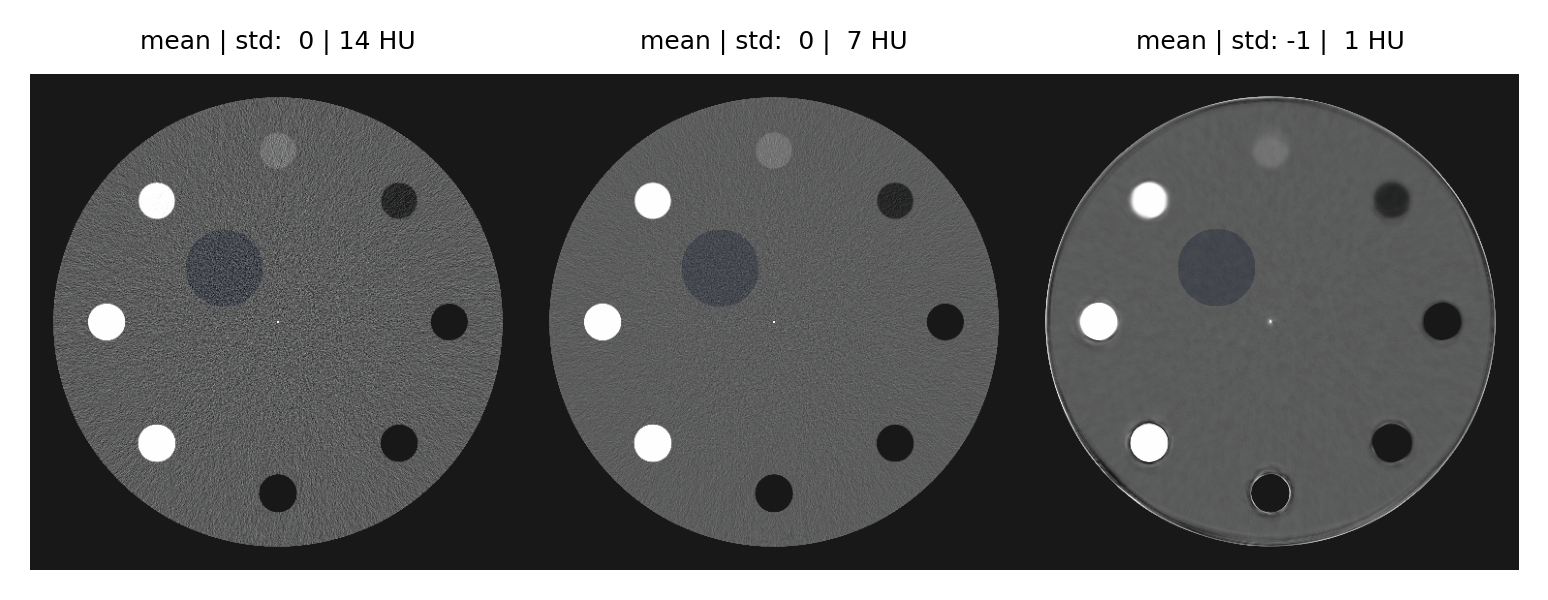

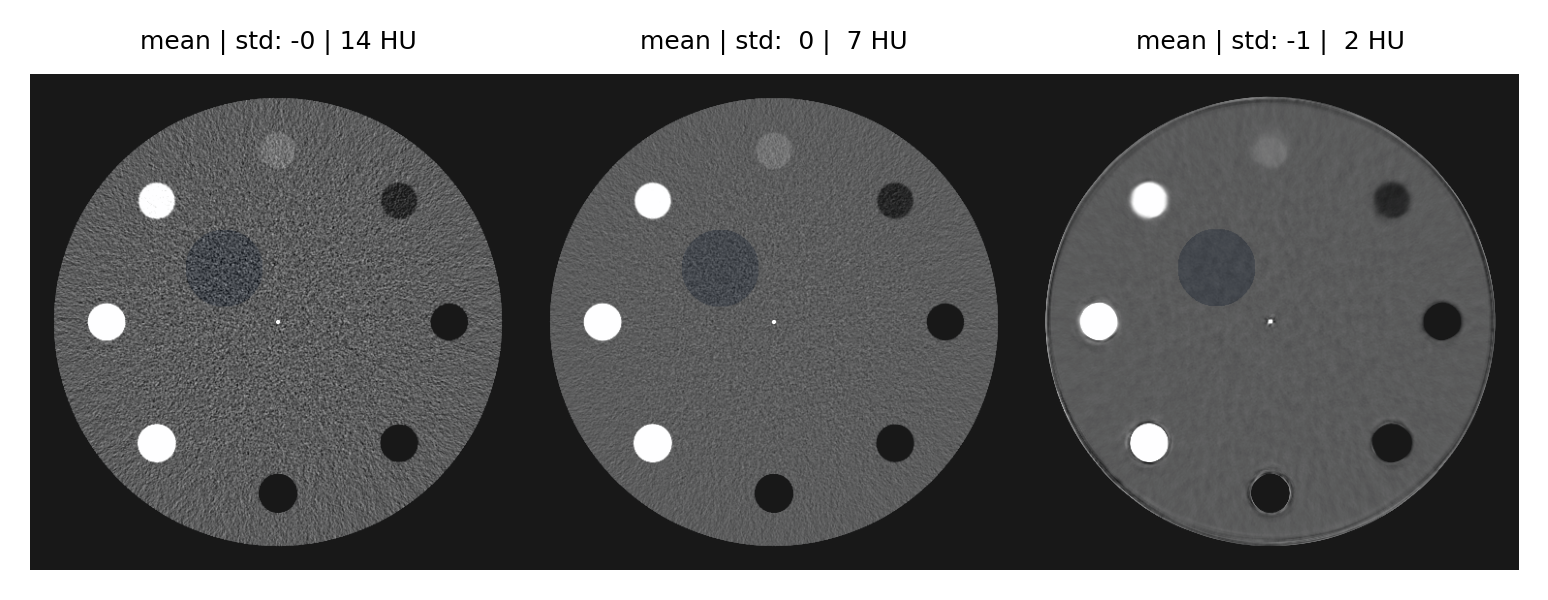

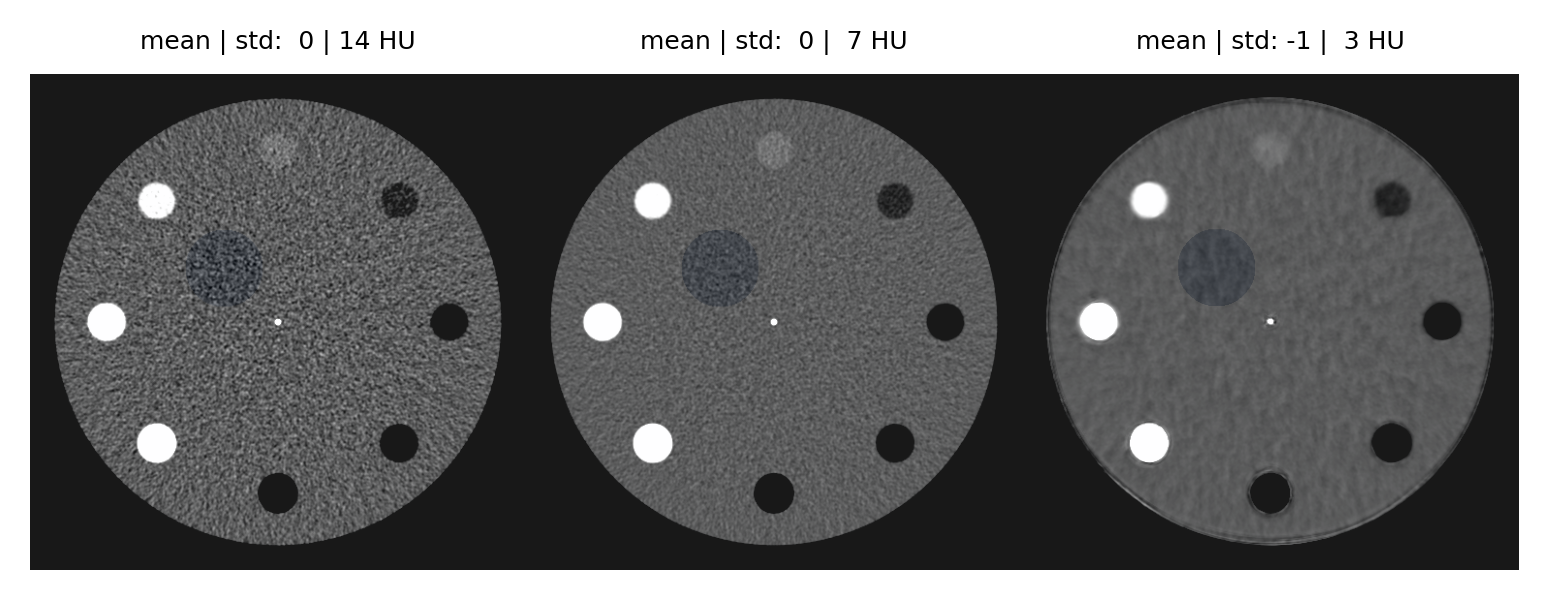

In [ ]:
model = redcnn
show_examples(model, PediatricIQDataset(os.environ['PEDIATRICIQ_PATH'], subgroup='adult'))
show_examples(model, PediatricIQDataset(os.environ['PEDIATRICIQ_PATH'], subgroup='child'))
show_examples(model, PediatricIQDataset(os.environ['PEDIATRICIQ_PATH'], subgroup='newborn'))

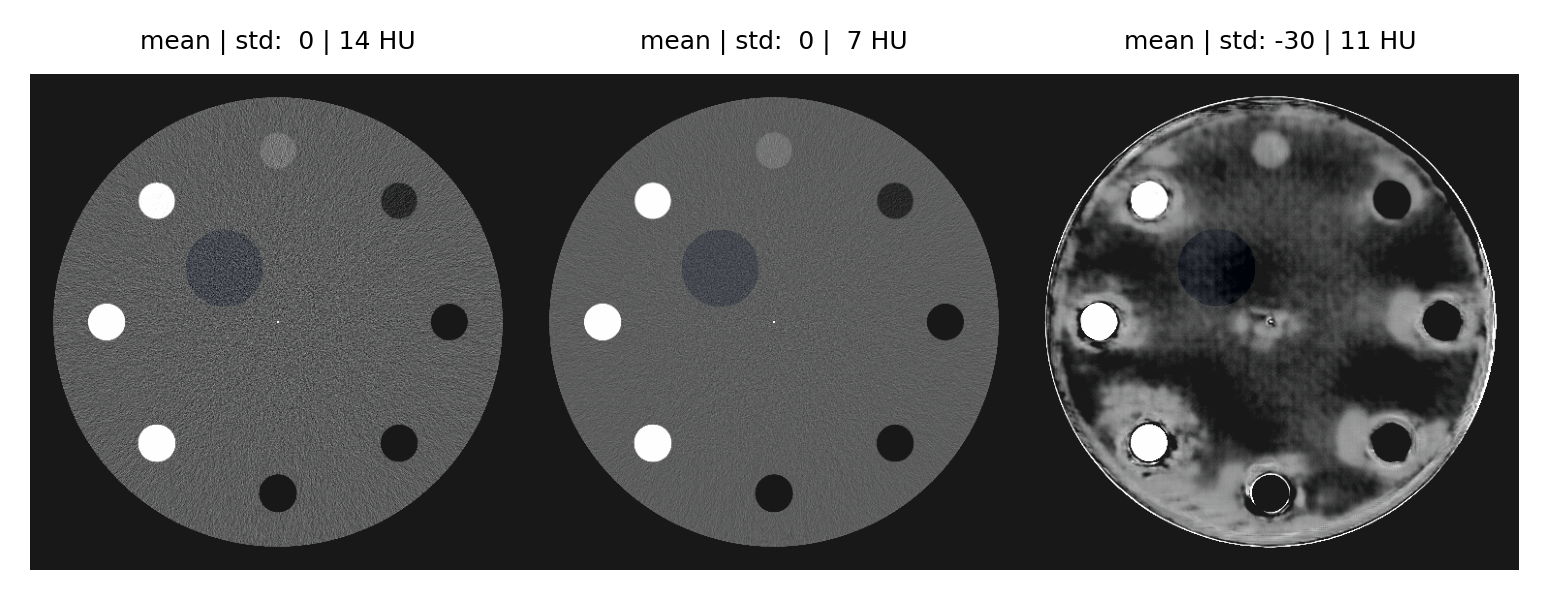

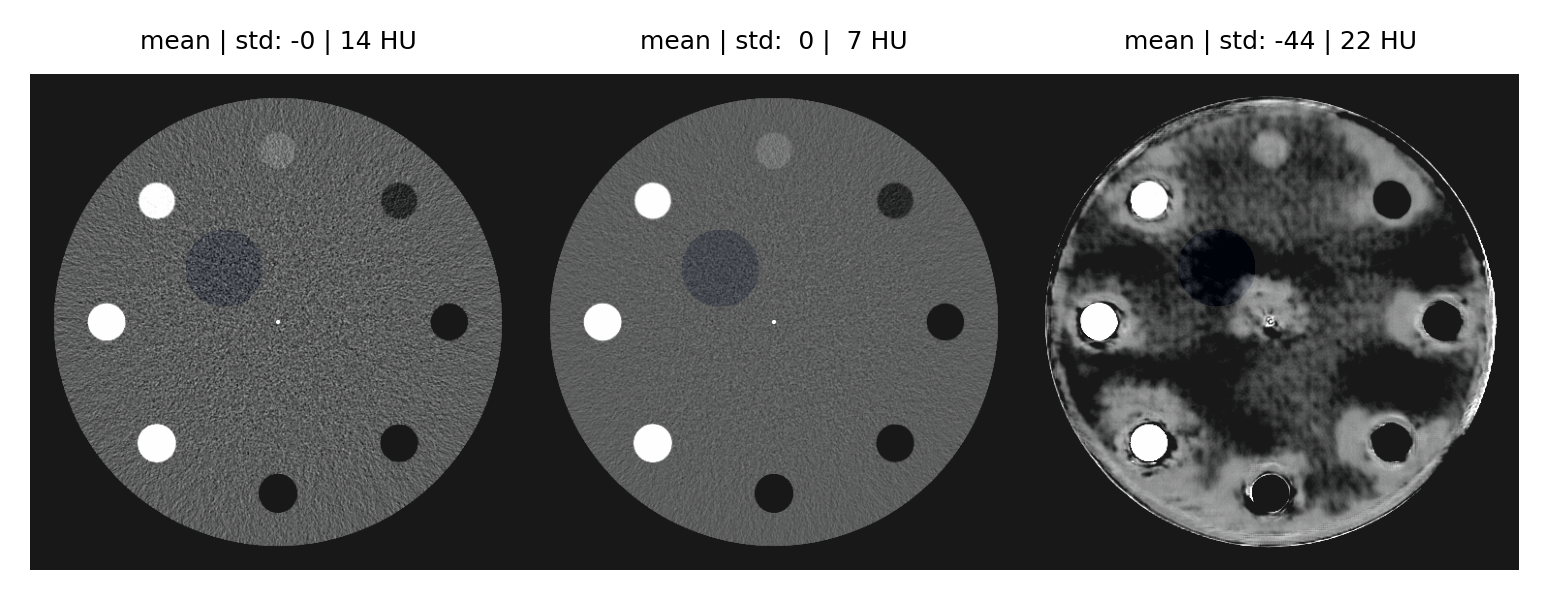

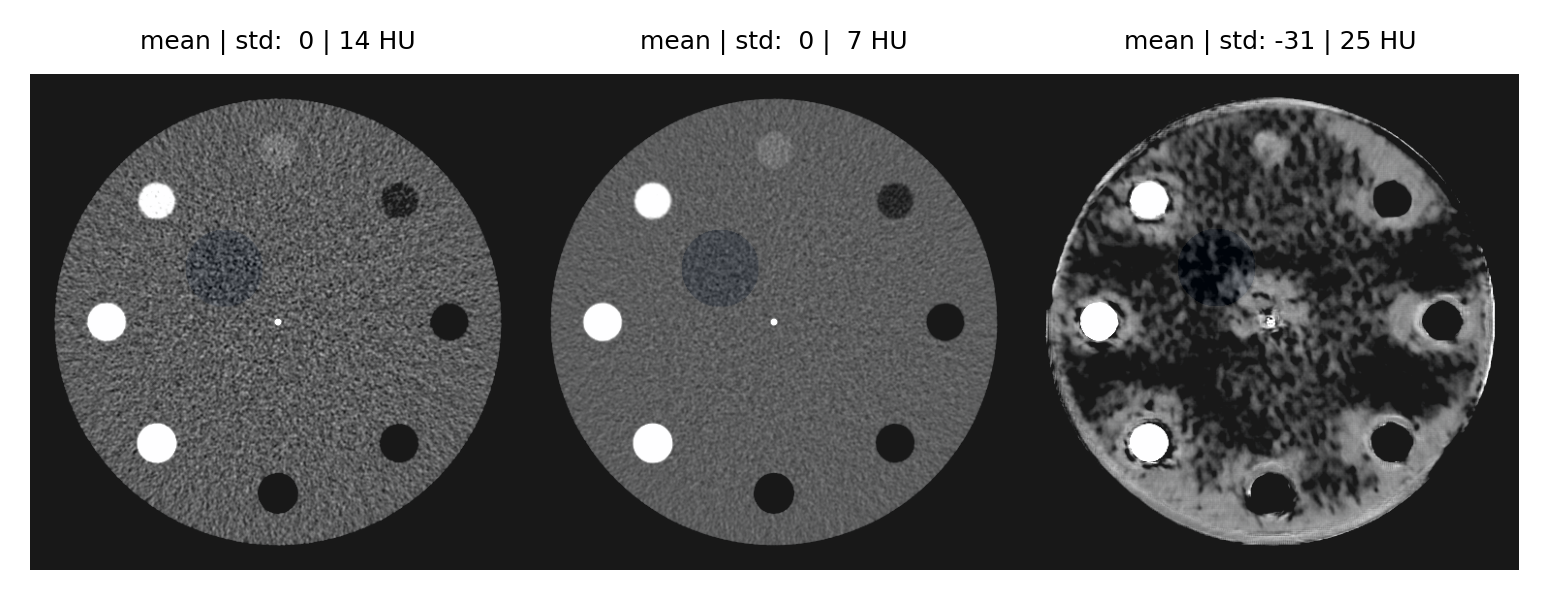

In [ ]:
model = unet
show_examples(model, PediatricIQDataset(os.environ['PEDIATRICIQ_PATH'], subgroup='adult'))
show_examples(model, PediatricIQDataset(os.environ['PEDIATRICIQ_PATH'], subgroup='child'))
show_examples(model, PediatricIQDataset(os.environ['PEDIATRICIQ_PATH'], subgroup='newborn'))

Interesting, the UNET does better when its closer to its training distribution (more anthropomorphic) but crumbles on phantoms, whereas REDCNN is simpler and doesn't preserve sharpness as well as UNet, its fuzzier but is more generalizable due to its simplicity.

Can make a similar argument with the anthropomorphic on the newborn, you get those weird spikes.

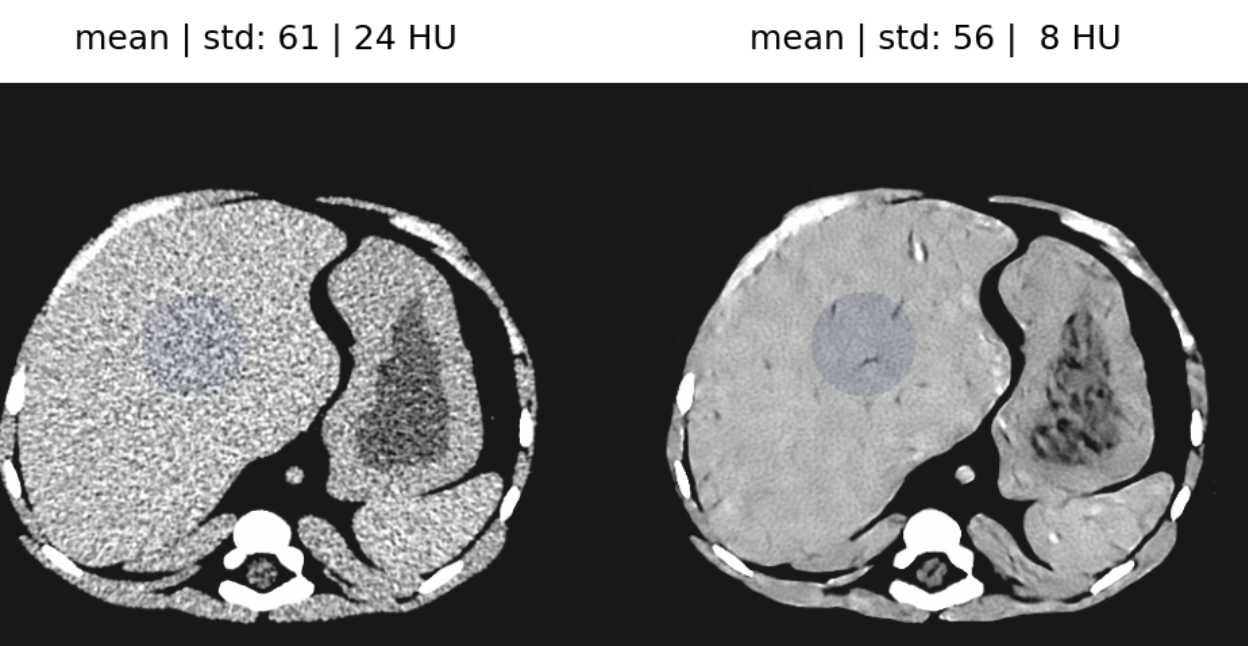

That you don't see with REDCNN, its just less denoised:

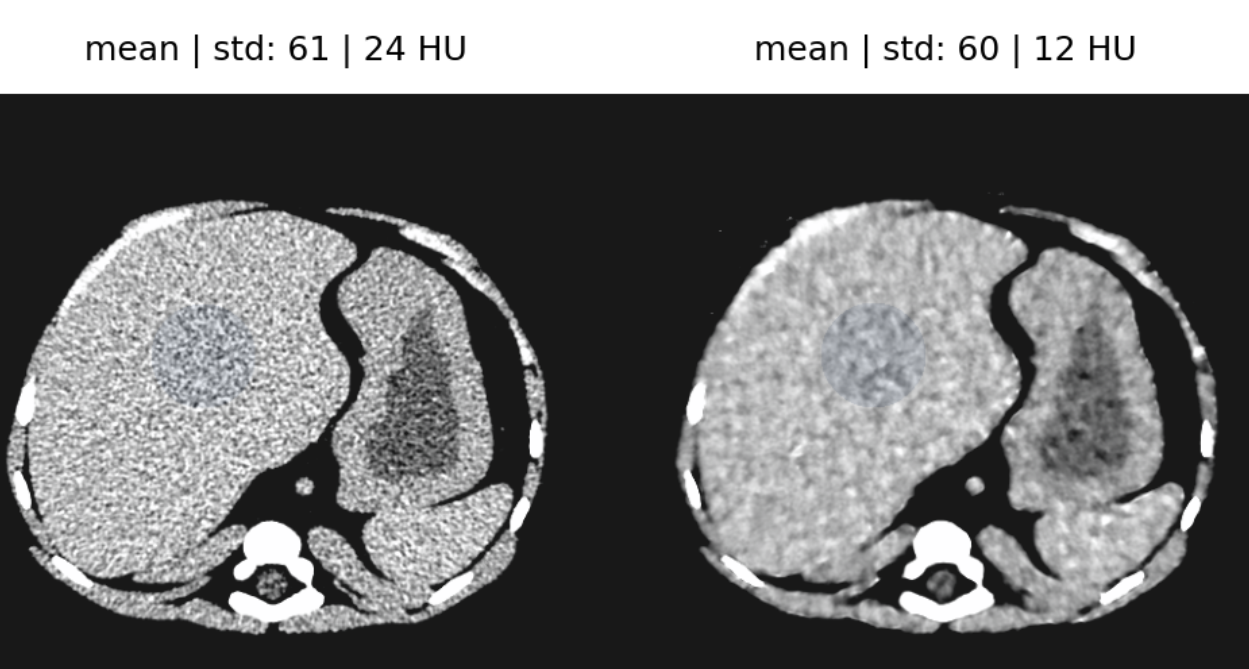

# fnames = trainer.predict(model=model, dataloaders=(anthro, peds))

Explore adding DataModules for the anthro and peds and can cut down on code even more as it looks like the trainer can load multiple dataloaders (and models?) better following pytorch lightning paradigms will make my life easier

In [ ]:
from utils import study_viewer, browse_studies

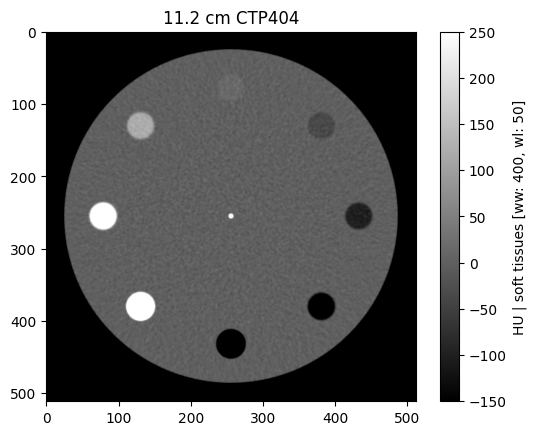

In [28]:
meta['Name'] = meta.name
meta['instance'] = meta['slice']
browse_studies(meta)

In [ ]:
study_viewer(meta)

interactive(children=(Dropdown(description='phantom', options=('CTP404', 'MITA-LCD', 'uniform', 'anthropomorph…